# AWS API Label Propagation

In [1]:
# Import required modules
import json
import config
from data_manager import DataManager
from label_propagation import WithinServiceLabelPropagator, CrossServiceLabelPropagator
from evaluator import Evaluator
from animation import create_animation
from IPython.display import display
from visualization import (
    print_evaluation_summary,
    create_propagation_dashboard,
    plot_comparison
)

In [2]:
# User-configurable parameters for propagation
VERBOSE = True  # Set to False to suppress output messages

# Embedding formats for different propagation types
WITHIN_SERVICE_EMBEDDING_FORMAT = 'with_params'  # or 'method_only', 'with_service_params'
CROSS_SERVICE_EMBEDDING_FORMAT = 'with_params'   # typically 'method_only' for cross-service
ALL_TO_ALL_EMBEDDING_FORMAT = 'with_params'      # typically 'method_only' for all-to-all

# Whether to save propagation history for animation
SAVE_HISTORY = True

## Step 1: Initialize and Load Data

In [3]:
# Initialize data manager
data_manager = DataManager()

# Load embeddings for labeled services
data_manager.load_method_embeddings(config.LABELED_SERVICES, WITHIN_SERVICE_EMBEDDING_FORMAT)

# Load or build Annoy indexes
if config.ANNOY_INDEXES_DIR.exists() and any(config.ANNOY_INDEXES_DIR.iterdir()):
    print(f"\n📂 Loading existing Annoy indexes from {config.ANNOY_INDEXES_DIR}")
    data_manager.load_indexes()
else:
    print(f"\n📁 Creating new Annoy indexes directory: {config.ANNOY_INDEXES_DIR}")
    config.ANNOY_INDEXES_DIR.mkdir(exist_ok=True, parents=True)
    
    print("\n🔧 Building Annoy indexes for each service...")
    for service in data_manager.service_methods.keys():
        print(f"   Building index for {service}...")
        data_manager.build_service_index(service)
    
    print("\n💾 Saving Annoy indexes...")
    data_manager.save_indexes()

🏷️ Loaded 85 manual labels
📂 Loading embeddings for services: ['S3', 'DynamoDB', 'Lambda', 'EC2', 'IAM', 'SSM', 'SQS', 'SNS']
📊 Using embedding format: with_params
📁 S3: 113 methods
📁 DynamoDB: 61 methods
📁 Lambda: 72 methods
📁 EC2: 661 methods
📁 IAM: 168 methods
📁 SSM: 148 methods
📁 SQS: 27 methods
📁 SNS: 46 methods
✅ Loaded 1296 method embeddings
🏷️ Found 85 labeled methods

📂 Loading existing Annoy indexes from ../../embeddings/annoy_indexes
📂 Loaded Annoy index for s3: 113 methods
📂 Loaded Annoy index for dynamodb: 61 methods
📂 Loaded Annoy index for lambda: 72 methods
📂 Loaded Annoy index for ec2: 661 methods
📂 Loaded Annoy index for iam: 168 methods
📂 Loaded Annoy index for ssm: 148 methods
📂 Loaded Annoy index for sqs: 27 methods
📂 Loaded Annoy index for sns: 46 methods


## Step 2: Data Analysis

In [4]:
# Initialize evaluator
evaluator = Evaluator(data_manager)

# Analyze data distribution and coverage
evaluator.analyze_label_distribution()
evaluator.analyze_method_coverage()

📊 Label Distribution by Service:
--------------------------------------------------
S3:
  none: 2 (20.0%)
  sink: 4 (40.0%)
  source: 4 (40.0%)

DYNAMODB:
  source: 5 (45.5%)
  sink: 3 (27.3%)
  none: 3 (27.3%)

LAMBDA:
  source: 4 (33.3%)
  sink: 6 (50.0%)
  none: 2 (16.7%)

EC2:
  sink: 7 (70.0%)
  none: 2 (20.0%)
  source: 1 (10.0%)

IAM:
  source: 2 (18.2%)
  sink: 8 (72.7%)
  none: 1 (9.1%)

SSM:
  source: 7 (70.0%)
  sink: 2 (20.0%)
  none: 1 (10.0%)

SQS:
  none: 4 (40.0%)
  source: 3 (30.0%)
  sink: 3 (30.0%)

SNS:
  none: 3 (27.3%)
  sink: 5 (45.5%)
  source: 3 (27.3%)

📈 Method Coverage Analysis:
--------------------------------------------------
S3:
📊 10/113 labeled (8.8% coverage)
🔍 103 methods need propagation
DYNAMODB:
📊 11/61 labeled (18.0% coverage)
🔍 50 methods need propagation
LAMBDA:
📊 12/72 labeled (16.7% coverage)
🔍 60 methods need propagation
EC2:
📊 10/661 labeled (1.5% coverage)
🔍 651 methods need propagation
IAM:
📊 11/168 labeled (6.5% coverage)
🔍 157 methods ne

## Step 3: Model Evaluation and Parameter Tuning

In [ ]:
# Find optimal k value
best_k = evaluator.find_optimal_k()

# Evaluate propagation performance
evaluation_results = evaluator.evaluate_propagation(k=best_k)

## Step 4: Within-Service Label Propagation

In [ ]:
# Initialize propagator
within_propagator = WithinServiceLabelPropagator(data_manager)

In [ ]:
# Run adaptive within-service propagation
final_predictions = within_propagator.propagate_all_services(
    k=best_k,
    threshold=config.DEFAULT_SERVICE_THRESHOLD,
    max_iterations=config.DEFAULT_MAX_ITERATIONS,
    min_confidence=config.DEFAULT_MIN_CONFIDENCE,
    min_threshold=config.DEFAULT_MIN_THRESHOLD,
    save_history=SAVE_HISTORY,
    verbose=VERBOSE,
    embedding_format=WITHIN_SERVICE_EMBEDDING_FORMAT
)

In [ ]:
# Save within-service predictions
within_service_metadata = {
    'type': 'within_service_propagation',
    'embedding_format': WITHIN_SERVICE_EMBEDDING_FORMAT,
    'k_neighbors': best_k,
    'initial_threshold': config.DEFAULT_SERVICE_THRESHOLD,
    'minimum_threshold': config.DEFAULT_MIN_THRESHOLD,
    'adaptive_threshold': True,
    'labeled_services': config.LABELED_SERVICES,
    'total_labeled_methods': len(data_manager.method_labels),
    'total_predictions': sum(len(pred) for pred in final_predictions.values())
}

data_manager.save_predictions(
    final_predictions, 
    config.WITHIN_SERVICE_PREDICTIONS_FILE, 
    within_service_metadata
)

## Step 5: Cross-Service Propagation

In [5]:
# Load all available service embeddings for cross-service propagation
methods_dir = config.EMBEDDINGS_DIR / 'methods'
all_services = [d.name for d in methods_dir.iterdir() if d.is_dir()]
services_to_load = [s for s in all_services if s.lower() not in data_manager.service_methods]

if services_to_load:
    print(f"🔄 Loading {len(services_to_load)} additional services...")
    data_manager.load_method_embeddings(services_to_load, CROSS_SERVICE_EMBEDDING_FORMAT)
    
    existing_indexes = [d.name for d in config.ANNOY_INDEXES_DIR.iterdir() if d.is_dir()]
    services_to_build = [s for s in services_to_load if s.lower() not in existing_indexes]
    
    if services_to_build:
        print(f"🔧 Building indexes for {len(services_to_build)} new services...")
        for service in services_to_build:
            data_manager.build_service_index(service)
        data_manager.save_indexes()
    else:
        data_manager.load_indexes()

print(f"📊 Total services available: {len(data_manager.service_methods)}")

🔄 Loading 23 additional services...
📂 Loading embeddings for services: ['SimpleDB', 'CognitoIdentity', 'SES', 'STS', 'Kinesis', 'SESV2', 'SSO', 'Lightsail', 'ElastiCache', 'Pinpoint', 'Glacier', 'EKS', 'ECS', 'OpsWorks', 'AppRunner', 'CloudFormation', 'DocDB', 'FSx', 'EventBridge', 'EBS', 'RDS', 'EFS', 'Neptune']
📊 Using embedding format: with_params
📁 SimpleDB: 14 methods
📁 CognitoIdentity: 27 methods
📁 SES: 75 methods
📁 STS: 13 methods
📁 Kinesis: 36 methods
📁 SESV2: 101 methods
📁 SSO: 8 methods
📁 Lightsail: 165 methods
📁 ElastiCache: 79 methods
📁 Pinpoint: 126 methods
📁 Glacier: 37 methods
📁 EKS: 61 methods
📁 ECS: 63 methods
📁 OpsWorks: 78 methods
📁 AppRunner: 41 methods
📁 CloudFormation: 92 methods
📁 DocDB: 59 methods
📁 FSx: 49 methods
📁 EventBridge: 61 methods
📁 EBS: 10 methods
📁 RDS: 167 methods
📁 EFS: 35 methods
📁 Neptune: 73 methods
✅ Loaded 2766 method embeddings
🏷️ Found 85 labeled methods
📂 Loaded Annoy index for s3: 113 methods
📂 Loaded Annoy index for dynamodb: 61 methods
📂

In [6]:
# Load within-service predictions from file for cross-service propagation
try:
    with open(config.WITHIN_SERVICE_PREDICTIONS_FILE, 'r') as f:
        within_service_data = json.load(f)
    loaded_within_service_predictions = within_service_data.get('predictions', {})
    print(f"✅ Loaded {sum(len(pred) for pred in loaded_within_service_predictions.values())} within-service predictions")
except FileNotFoundError:
    print("⚠️ Within-service predictions file not found")
    loaded_within_service_predictions = {}

✅ Loaded 1044 within-service predictions


### Group-Based Cross-Service Propagation (Prelabeled data only)

In [ ]:
cross_propagator = CrossServiceLabelPropagator(data_manager)

In [ ]:
# Run group-based cross-service propagation with adaptive thresholding
# Using only initial prelabeled methods (no within-service predictions)
group_cross_service_prelabeled = cross_propagator.propagate_all_groups_cross_service(
    k=best_k, 
    threshold=config.DEFAULT_SERVICE_THRESHOLD,
    min_threshold=config.DEFAULT_MIN_THRESHOLD,
    min_confidence=config.DEFAULT_MIN_CONFIDENCE,
    within_service_predictions=None,  # Only use initial prelabeled methods
    verbose=VERBOSE,
    embedding_format=CROSS_SERVICE_EMBEDDING_FORMAT
)

# Save prelabeled-only predictions
if group_cross_service_prelabeled:
    prelabeled_metadata = {
        'type': 'group_cross_service_prelabeled_only',
        'embedding_format': CROSS_SERVICE_EMBEDDING_FORMAT,
        'k_neighbors': best_k,
        'initial_threshold': config.DEFAULT_SERVICE_THRESHOLD,
        'minimum_threshold': config.DEFAULT_MIN_THRESHOLD,
        'min_confidence': config.DEFAULT_MIN_CONFIDENCE,
        'groups_processed': list(group_cross_service_prelabeled.keys()),
        'total_predictions': sum(
            len(service_preds) 
            for group_data in group_cross_service_prelabeled.values() 
            for service_preds in group_data.values()
        ),
        'group_configuration': config.CROSS_SERVICE_GROUPS,
        'uses_within_service_predictions': False  # Mark that this uses only initial labels
    }
    
    data_manager.save_predictions(
        group_cross_service_prelabeled, 
        config.GROUP_CROSS_SERVICE_PRELABELED_FILE, 
        prelabeled_metadata
    )

### Group-Based Cross-Service Propagation (Enhanced with within-service predictions)

In [ ]:
# Run group-based cross-service propagation with adaptive thresholding
group_cross_service_enhanced = cross_propagator.propagate_all_groups_cross_service(
    k=best_k, 
    threshold=config.DEFAULT_SERVICE_THRESHOLD,
    min_threshold=config.DEFAULT_MIN_THRESHOLD,
    min_confidence=config.DEFAULT_MIN_CONFIDENCE,
    within_service_predictions=loaded_within_service_predictions,
    verbose=VERBOSE,
    embedding_format=CROSS_SERVICE_EMBEDDING_FORMAT
)

# Save enhanced predictions
if group_cross_service_enhanced:
    enhanced_metadata = {
        'type': 'group_cross_service_enhanced',
        'embedding_format': CROSS_SERVICE_EMBEDDING_FORMAT,
        'k_neighbors': best_k,
        'initial_threshold': config.DEFAULT_SERVICE_THRESHOLD,
        'minimum_threshold': config.DEFAULT_MIN_THRESHOLD,
        'min_confidence': config.DEFAULT_MIN_CONFIDENCE,
        'groups_processed': list(group_cross_service_enhanced.keys()),
        'total_predictions': sum(
            len(service_preds) 
            for group_data in group_cross_service_enhanced.values() 
            for service_preds in group_data.values()
        ),
        'group_configuration': config.CROSS_SERVICE_GROUPS,
        'uses_within_service_predictions': True  # Mark that this uses within-service predictions
    }
    
    data_manager.save_predictions(
        group_cross_service_enhanced, 
        config.GROUP_CROSS_SERVICE_ENHANCED_FILE, 
        enhanced_metadata
    )

### All-to-All Cross-Service Propagation

In [ ]:
# Run all-to-all cross-service propagation with adaptive thresholding
all_to_all_predictions = cross_propagator.propagate_all_to_all_cross_service(
    k=best_k,
    threshold=config.DEFAULT_SERVICE_THRESHOLD,  # Lower initial threshold for broader coverage
    min_threshold=config.DEFAULT_MIN_THRESHOLD,  # Even lower minimum for all-to-all
    min_confidence=config.DEFAULT_MIN_CONFIDENCE,
    within_service_predictions=loaded_within_service_predictions,
    verbose=VERBOSE,
    embedding_format=ALL_TO_ALL_EMBEDDING_FORMAT
)

# Save all-to-all predictions
if all_to_all_predictions:
    all_to_all_metadata = {
        'type': 'all_to_all_cross_service_propagation',
        'embedding_format': ALL_TO_ALL_EMBEDDING_FORMAT,
        'k_neighbors': best_k,
        'initial_threshold': config.DEFAULT_SERVICE_THRESHOLD,
        'minimum_threshold': config.DEFAULT_MIN_THRESHOLD,
        'min_confidence': config.DEFAULT_MIN_CONFIDENCE,
        'total_predictions': sum(len(pred) for pred in all_to_all_predictions.values())
    }
    
    data_manager.save_predictions(
        all_to_all_predictions, 
        config.ALL_TO_ALL_CROSS_SERVICE_PREDICTIONS_FILE, 
        all_to_all_metadata
    )

## Step 6: Results Comparisions

In [7]:
# Load all prediction files for independent execution of comparision and visualization sections

# Load within-service predictions from file for cross-service propagation
try:
    with open(config.WITHIN_SERVICE_PREDICTIONS_FILE, 'r') as f:
        within_service_data = json.load(f)
    loaded_within_service_predictions = within_service_data.get('predictions', {})
    print(f"✅ Loaded {sum(len(pred) for pred in loaded_within_service_predictions.values())} within-service predictions")
except FileNotFoundError:
    print("⚠️ Within-service predictions file not found")
    loaded_within_service_predictions = {}
    
# Load group-based cross-service predictions (prelabeled only)
try:
    with open(config.GROUP_CROSS_SERVICE_PRELABELED_FILE, 'r') as f:
        prelabeled_data = json.load(f)
    group_cross_service_prelabeled = prelabeled_data.get('predictions', {})
    prelabeled_count = sum(len(service_preds) for group_data in group_cross_service_prelabeled.values() 
                          for service_preds in group_data.values())
    print(f"✅ Loaded {prelabeled_count} group cross-service predictions (prelabeled only)")
except FileNotFoundError:
    print("⚠️ Group cross-service (prelabeled) predictions file not found")
    group_cross_service_prelabeled = {}

# Load group-based cross-service predictions (enhanced)
try:
    with open(config.GROUP_CROSS_SERVICE_ENHANCED_FILE, 'r') as f:
        enhanced_data = json.load(f)
    group_cross_service_enhanced = enhanced_data.get('predictions', {})
    enhanced_count = sum(len(service_preds) for group_data in group_cross_service_enhanced.values() 
                        for service_preds in group_data.values())
    print(f"✅ Loaded {enhanced_count} group cross-service predictions (enhanced)")
except FileNotFoundError:
    print("⚠️ Group cross-service (enhanced) predictions file not found")
    group_cross_service_enhanced = {}

# Load all-to-all cross-service predictions
try:
    with open(config.ALL_TO_ALL_CROSS_SERVICE_PREDICTIONS_FILE, 'r') as f:
        all_to_all_data = json.load(f)
    all_to_all_predictions = all_to_all_data.get('predictions', {})
    print(f"✅ Loaded {sum(len(pred) for pred in all_to_all_predictions.values())} all-to-all cross-service predictions")
except FileNotFoundError:
    print("⚠️ All-to-all cross-service predictions file not found")
    all_to_all_predictions = {}

✅ Loaded 1044 within-service predictions
✅ Loaded 1188 group cross-service predictions (prelabeled only)
✅ Loaded 1192 group cross-service predictions (enhanced)
✅ Loaded 1404 all-to-all cross-service predictions


📊 Group Methods Comparison Summary
🤝 Overall Agreement Rate: 0.556
📈 Prelabeled-only predictions: 1188
🚀 Enhanced predictions: 1192
⬆️  Additional predictions: 4 (0.3% improvement)

📋 Service-level Agreement Rates:
   • elasticache: 1.000 (77/77) | +0 predictions
   • eventbridge: 0.850 (51/60) | +0 predictions
   • sts: 0.778 (7/9) | +2 predictions
   • neptune: 0.928 (64/69) | +-2 predictions
   • eks: 1.000 (59/59) | +0 predictions
   • ecs: 1.000 (61/61) | +0 predictions
   • ses: 0.580 (40/69) | +3 predictions
   • pinpoint: 0.439 (54/123) | +0 predictions
   • fsx: 0.119 (5/42) | +-1 predictions
   • glacier: 0.314 (11/35) | +0 predictions
   • lightsail: 0.160 (26/163) | +0 predictions
   • sso: 1.000 (4/4) | +2 predictions
   • cognitoidentity: 1.000 (23/23) | +2 predictions
   • ebs: 0.000 (0/6) | +2 predictions
   • sesv2: 0.898 (88/98) | +0 predictions
   • simpledb: 0.800 (8/10) | +-2 predictions
   • kinesis: 0.171 (6/35) | +0 predictions
   • efs: 0.091 (3/33) | +0 predic

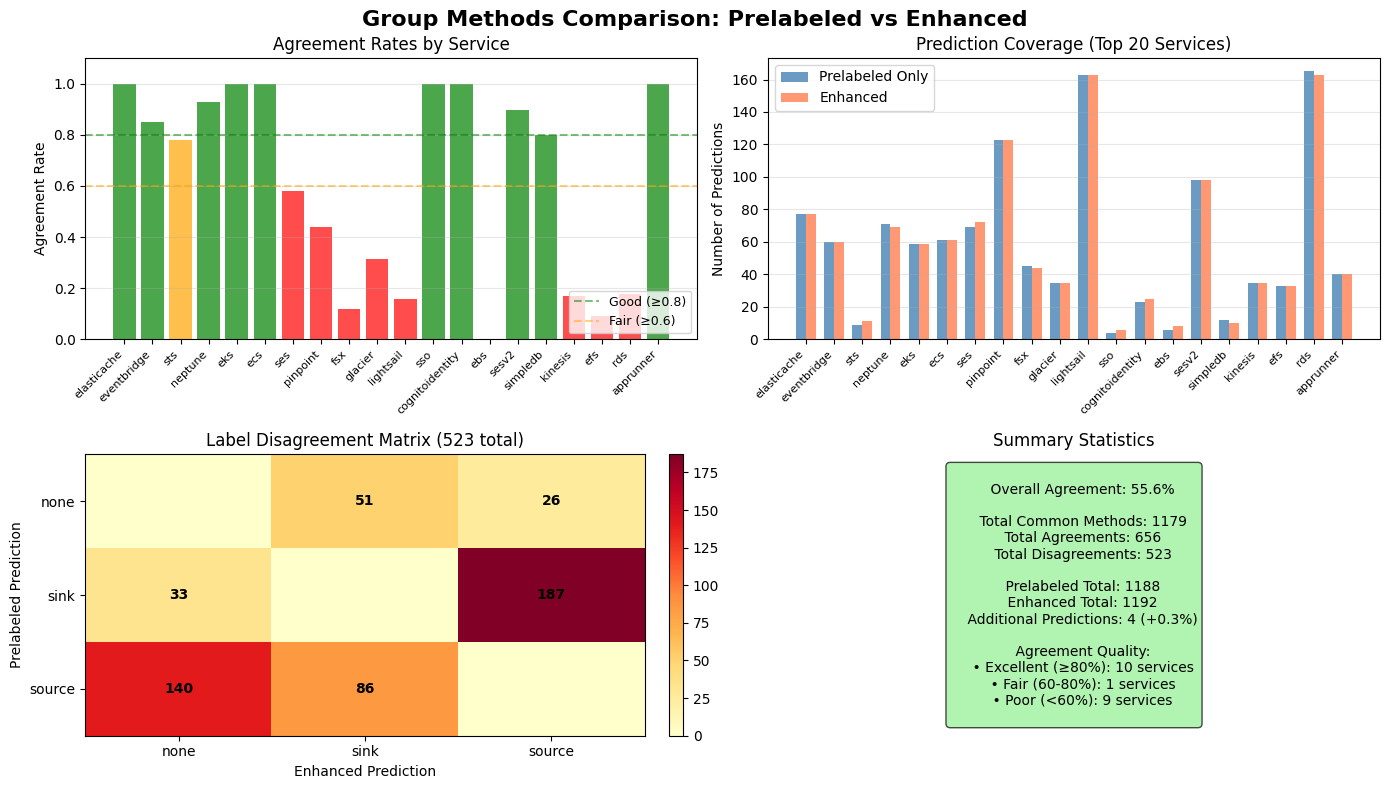

In [8]:
# Compare the two group-based approaches (prelabeled vs enhanced)
group_comparison_results = evaluator.compare_group_methods(
    group_cross_service_prelabeled,
    group_cross_service_enhanced
)

# Save group comparison results
if group_comparison_results:
    with open(config.GROUP_COMPARISON_FILE, 'w') as f:
        json.dump(group_comparison_results, f, indent=2, default=str)
    
    print(f"📊 Group methods comparison saved to: {config.GROUP_COMPARISON_FILE}")
    
    # Visualize group comparison
    plot_comparison(group_comparison_results, comparison_type='group_methods')

📊 Overall Agreement Rate: 0.510
🤝 Total Agreements: 560 / 1098
📈 Group-based predictions: 1192
🌍 All-to-all predictions: 1404

📋 Service-level Agreement Rates:
   • elasticache: 0.296 (21/71)
   • eventbridge: 0.889 (48/54)
   • sts: 1.000 (11/11)
   • neptune: 0.297 (19/64)
   • eks: 0.772 (44/57)
   • ecs: 0.119 (7/59)
   • ses: 0.583 (35/60)
   • pinpoint: 0.782 (86/110)
   • fsx: 0.643 (27/42)
   • glacier: 0.516 (16/31)
   • lightsail: 0.314 (48/153)
   • sso: 0.833 (5/6)
   • cognitoidentity: 1.000 (25/25)
   • ebs: 1.000 (8/8)
   • sesv2: 0.670 (61/91)
   • simpledb: 0.700 (7/10)
   • kinesis: 0.029 (1/34)
   • efs: 0.844 (27/32)
   • rds: 0.305 (43/141)
   • apprunner: 0.538 (21/39)

⚠️  Found 538 disagreements across all services
   Review disagreement_details in the returned comparison stats for specific conflicts
📊 Group vs All-to-All comparison saved to: summaries/cross_service_comparison.json


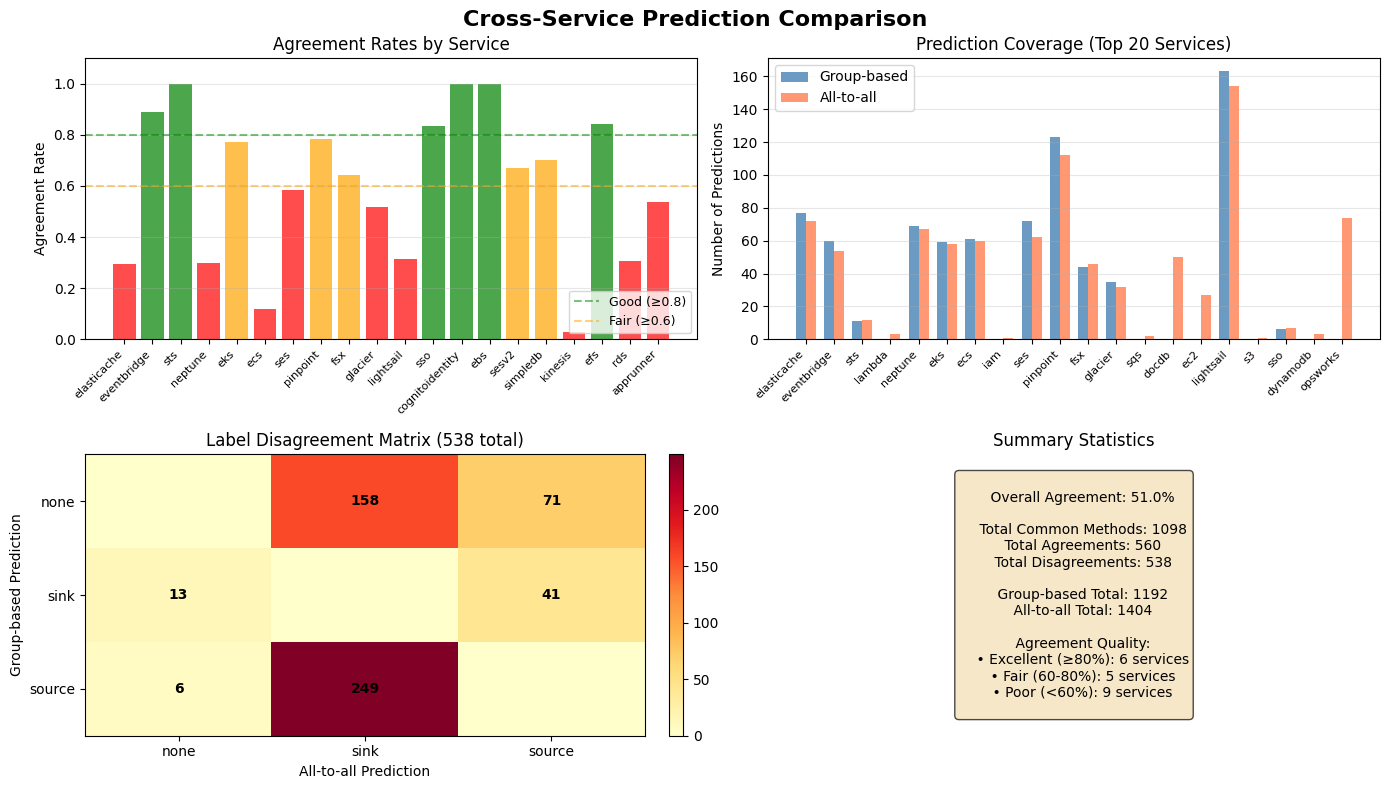

In [ ]:
# Compare the enhanced group-based approach with all-to-all
cross_comparison_results = evaluator.compare_cross_service_predictions(
    group_cross_service_enhanced, 
    all_to_all_predictions
)

# Save comparison results
if cross_comparison_results:
    with open(config.CROSS_SERVICE_COMPARISON_FILE, 'w') as f:
        json.dump(cross_comparison_results, f, indent=2, default=str)

    print(f"📊 Group vs All-to-All comparison saved to: {config.CROSS_SERVICE_COMPARISON_FILE}")
    
    # Visualize comparison
    plot_comparison(cross_comparison_results, comparison_type='cross_service')

## Step 7: Results Visualization

### Within-Service Visualization

🎨 Creating Within-Service Visualization Dashboard


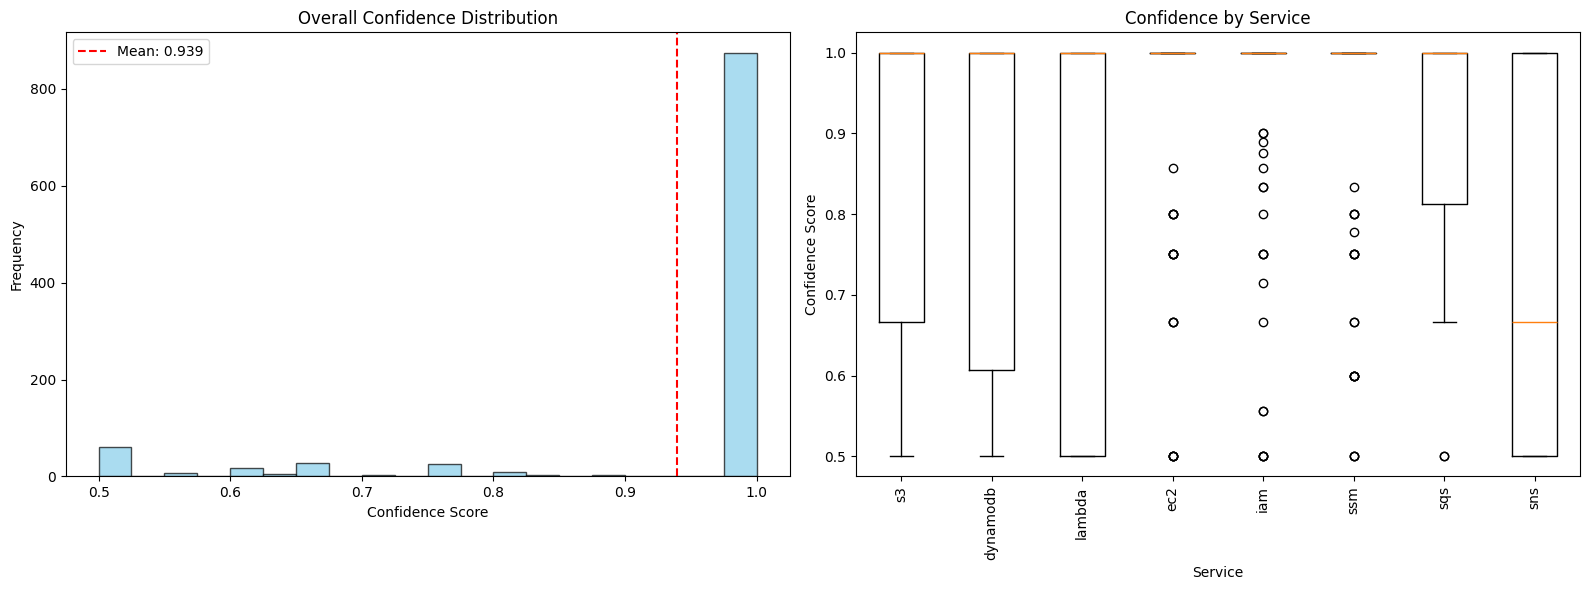

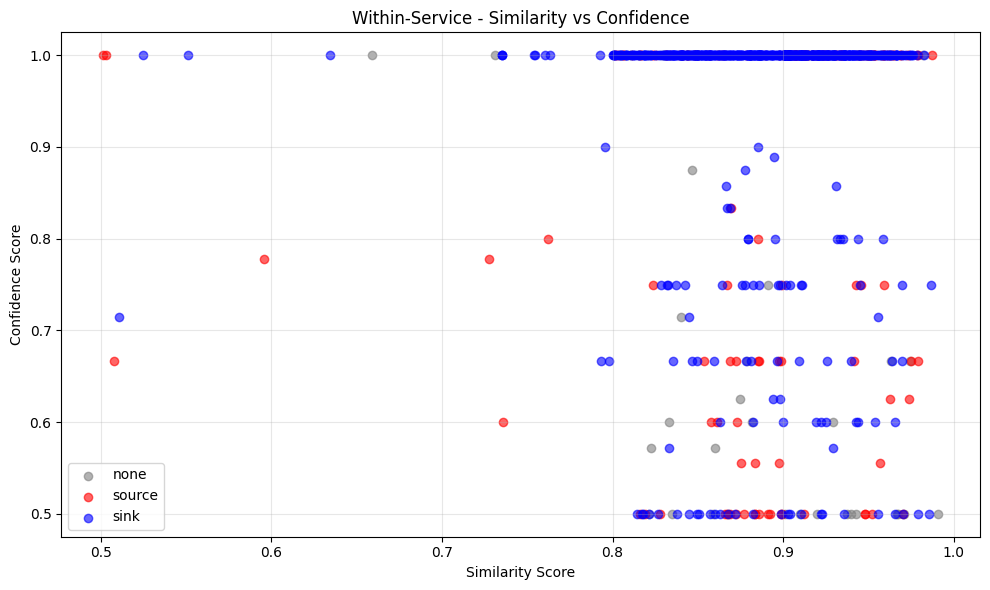

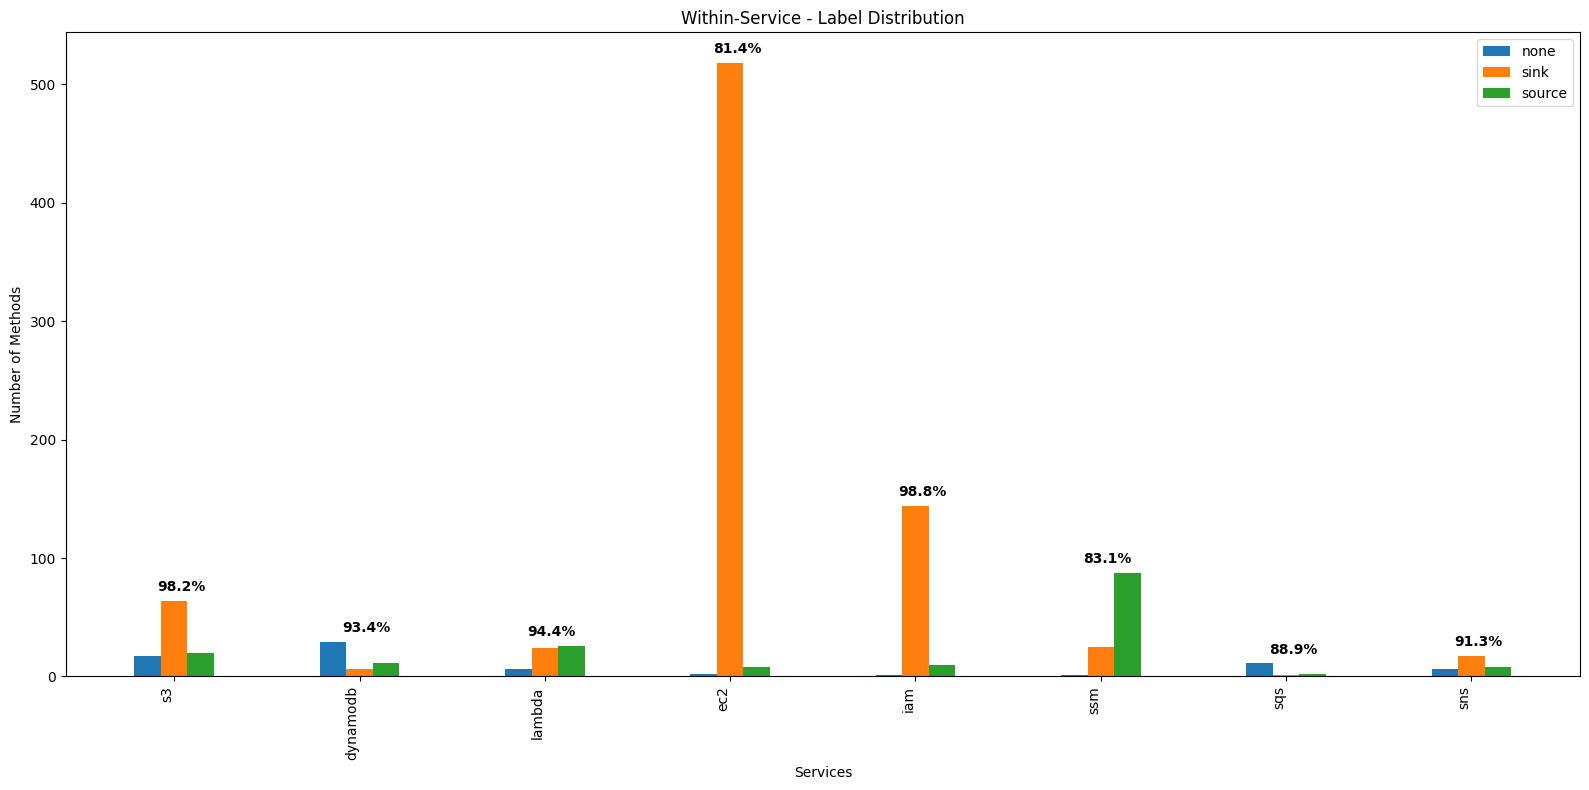

✅ Within-Service dashboard complete!


In [10]:
# Create visualization for within-service predictions
total_methods = {service: len(methods_list) for service, methods_list in data_manager.service_methods.items()}

create_propagation_dashboard(
    loaded_within_service_predictions, 
    total_methods, 
    data_manager.method_labels,
    title_prefix="Within-Service"
)

### Group-Based Cross-Service Visualization (Prelabeled data only)

🎨 Creating Group Cross-Service (Prelabeled Only) Visualization Dashboard


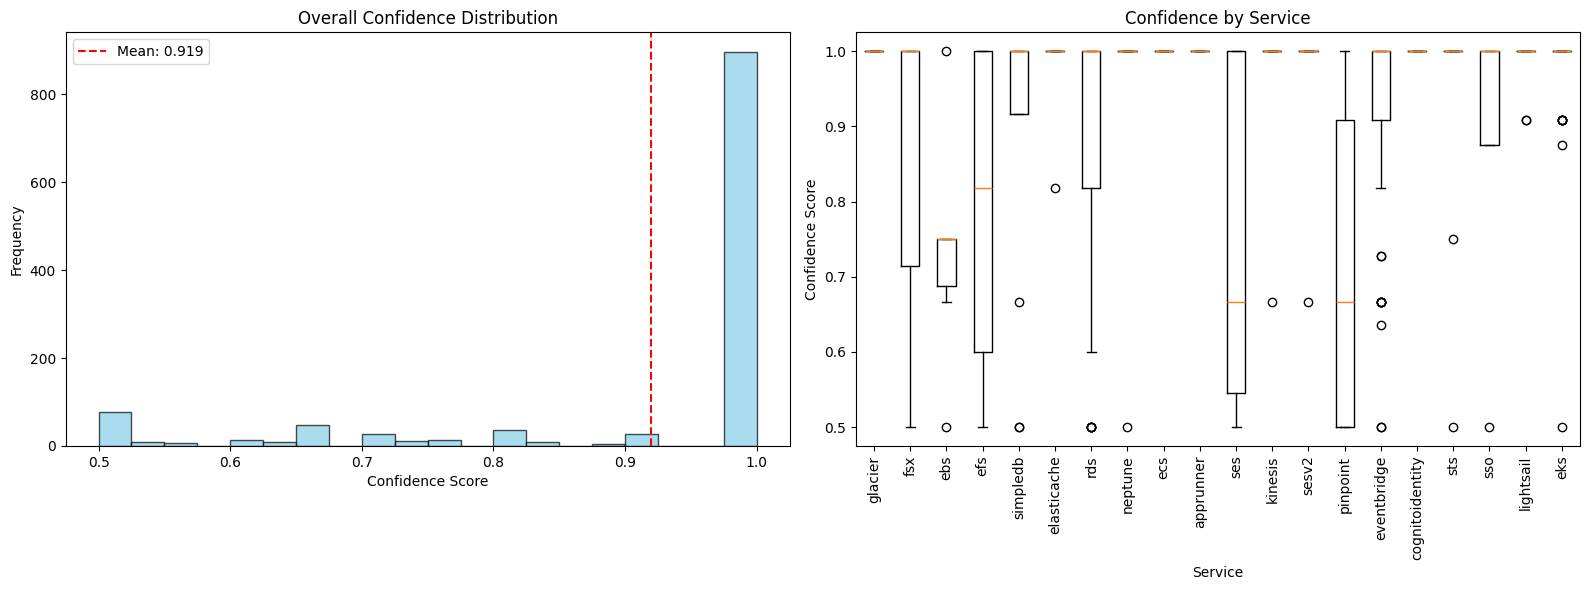

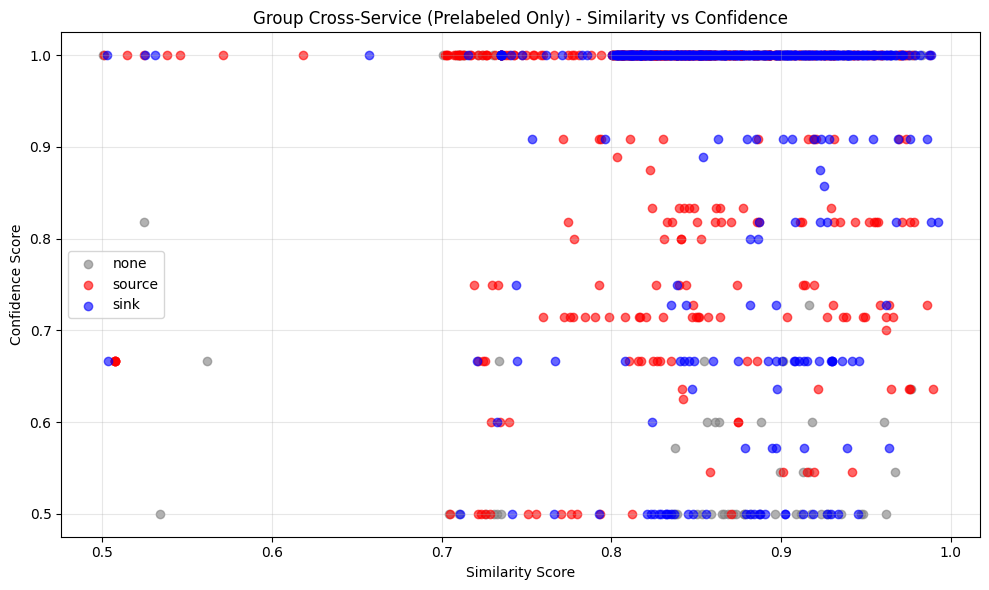

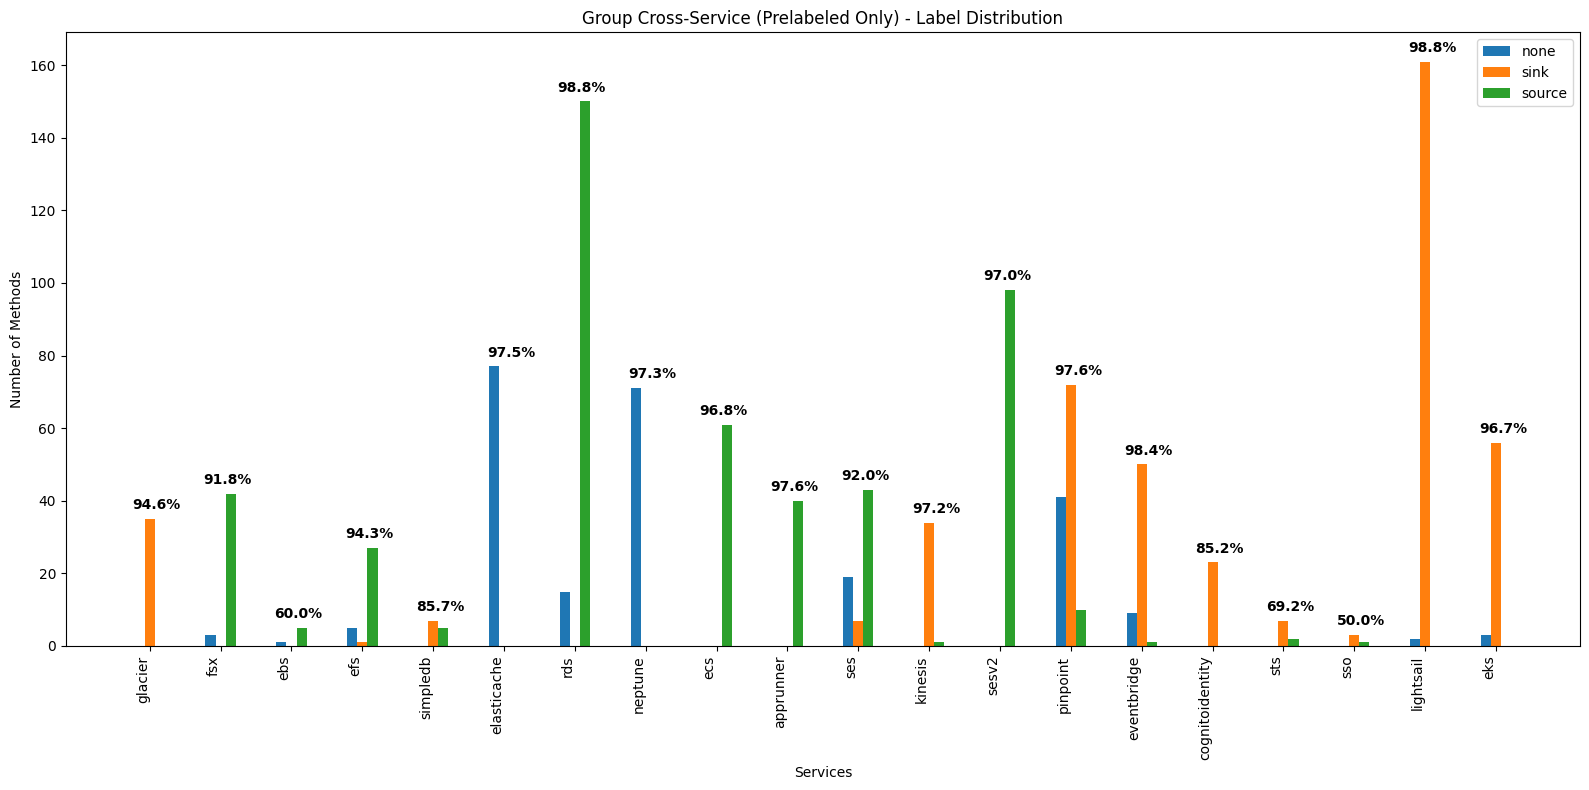

✅ Group Cross-Service (Prelabeled Only) dashboard complete!


In [11]:
# Flatten group predictions for visualization
if group_cross_service_prelabeled:
    prelabeled_flat = {}
    for group_name, group_data in group_cross_service_prelabeled.items():
        for service, service_predictions in group_data.items():
            if service not in prelabeled_flat:
                prelabeled_flat[service] = {}
            prelabeled_flat[service].update(service_predictions)
    
    create_propagation_dashboard(
        prelabeled_flat,
        total_methods,
        data_manager.method_labels,
        title_prefix="Group Cross-Service (Prelabeled Only)"
    )

### Group-Based Cross-Service Visualization (Enhanced)

🎨 Creating Group Cross-Service (Enhanced) Visualization Dashboard


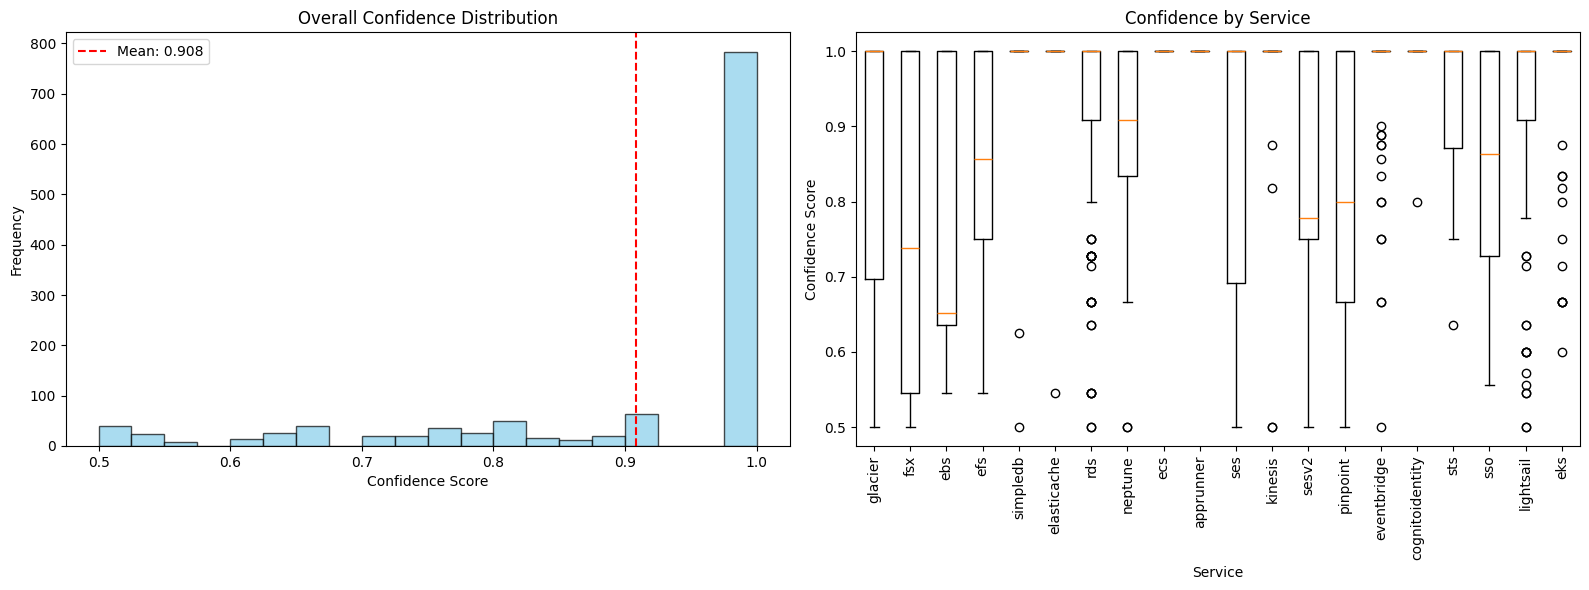

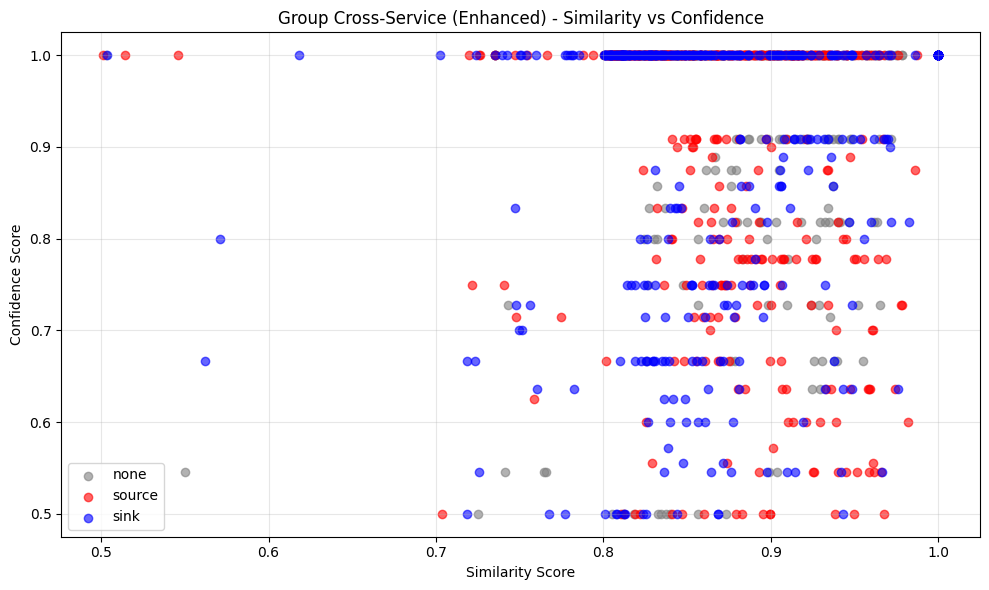

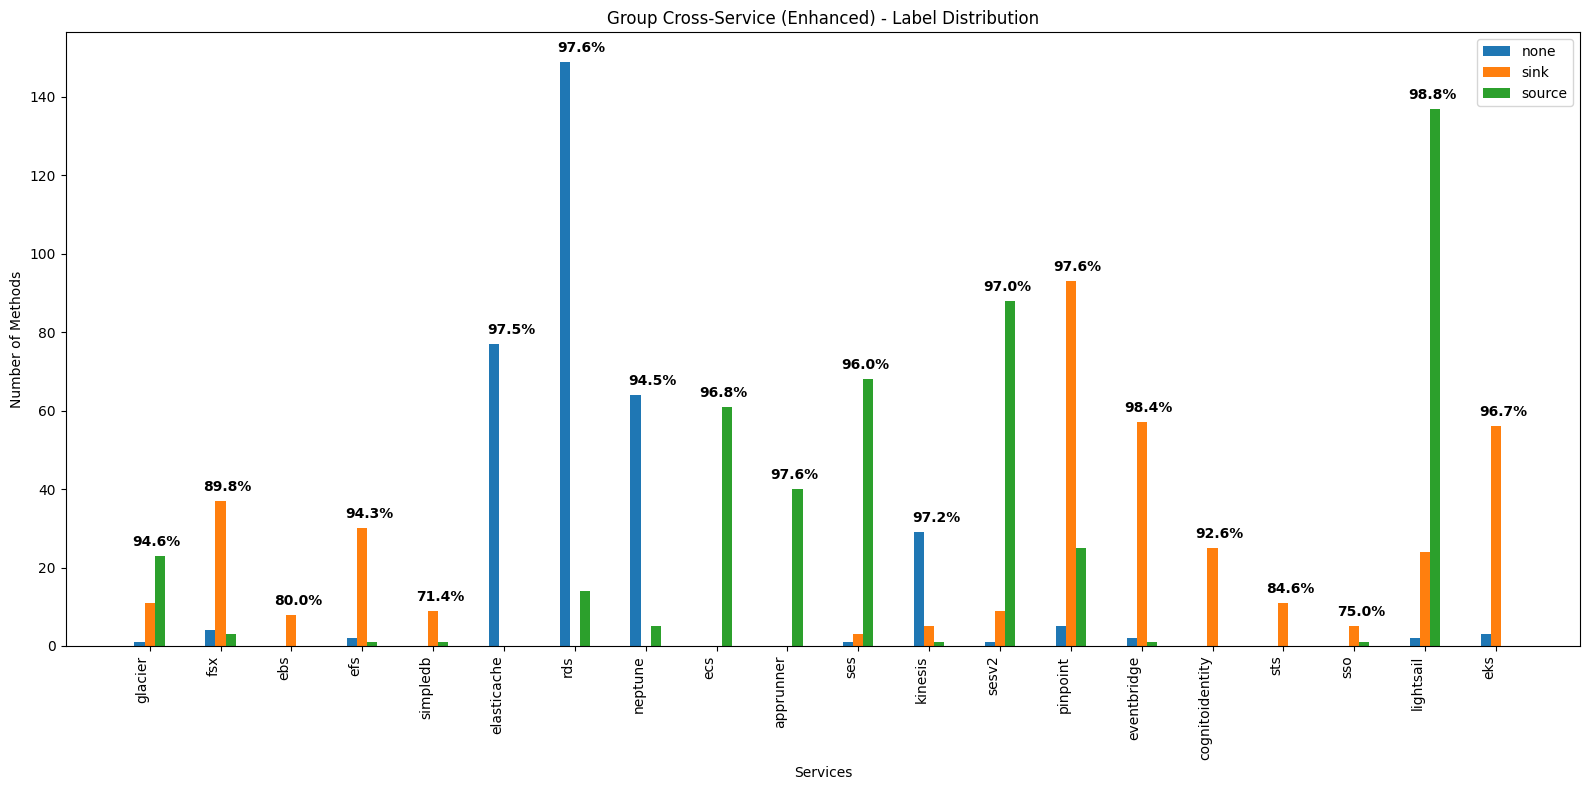

✅ Group Cross-Service (Enhanced) dashboard complete!


In [12]:
# Flatten group predictions for visualization
if group_cross_service_enhanced:
    enhanced_flat = {}
    for group_name, group_data in group_cross_service_enhanced.items():
        for service, service_predictions in group_data.items():
            if service not in enhanced_flat:
                enhanced_flat[service] = {}
            enhanced_flat[service].update(service_predictions)
    
    create_propagation_dashboard(
        enhanced_flat,
        total_methods,
        data_manager.method_labels,
        title_prefix="Group Cross-Service (Enhanced)"
    )

### All-to-All Cross-Service Visualization


🎨 Creating All-to-All Cross-Service Visualization Dashboard


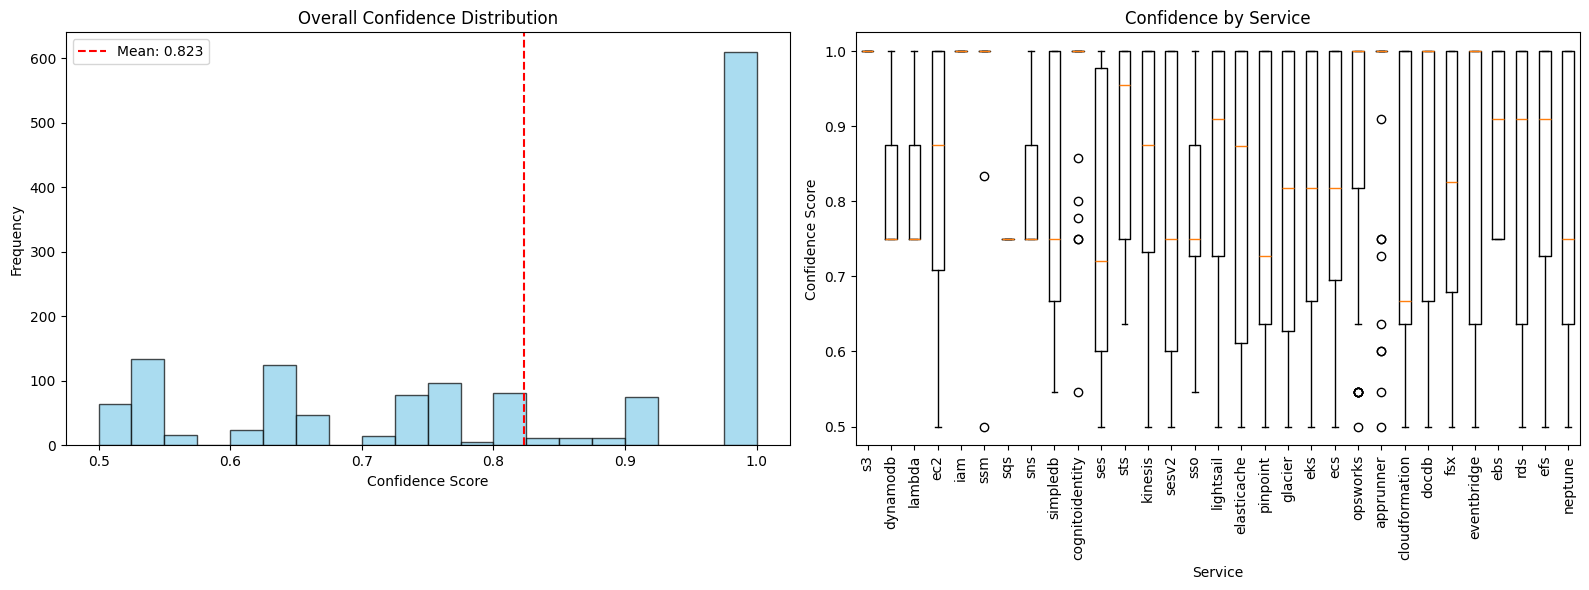

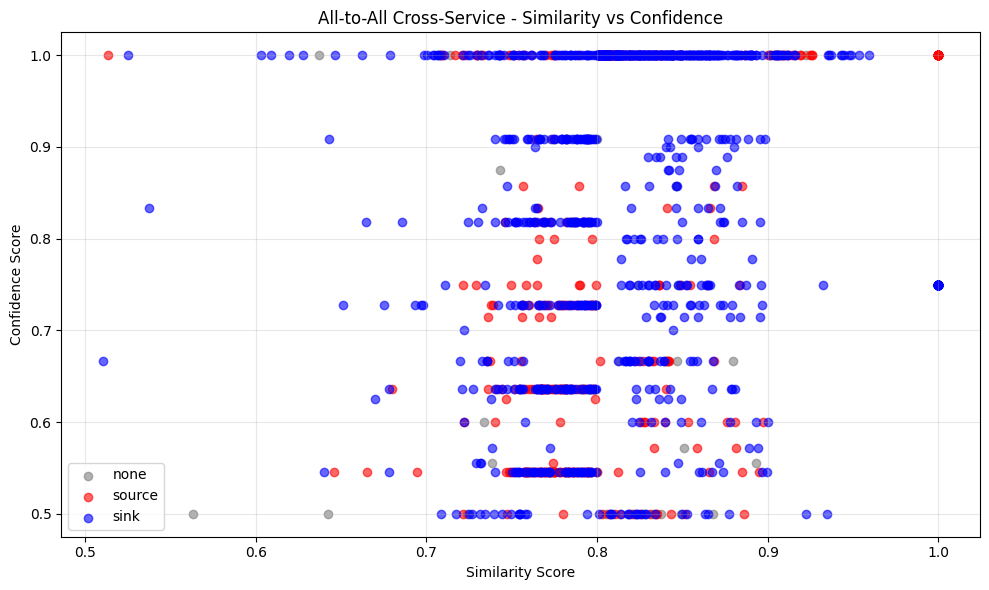

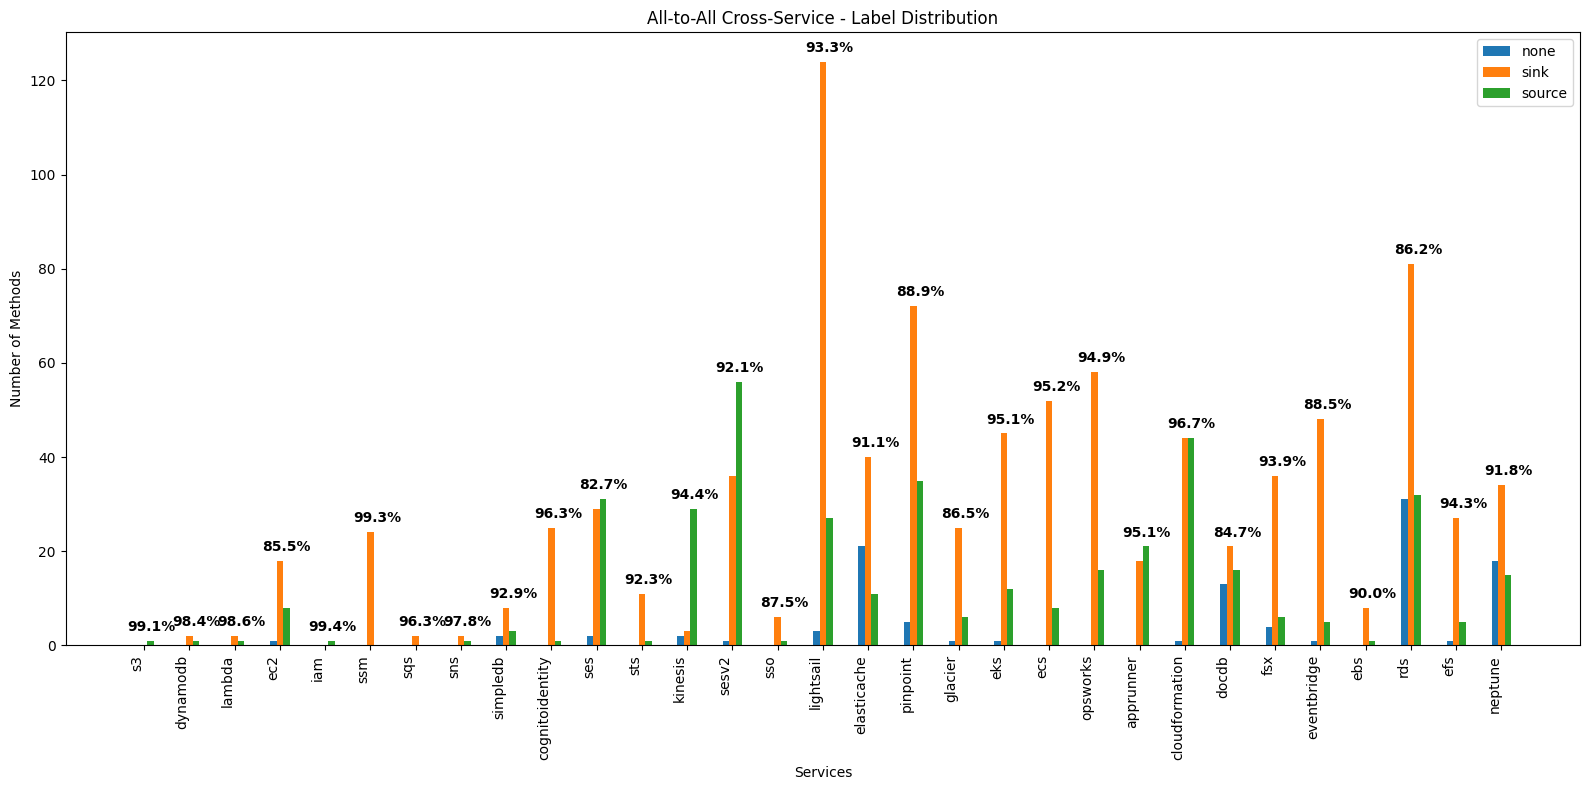

✅ All-to-All Cross-Service dashboard complete!


In [13]:
# Create visualization for all-to-all predictions
if all_to_all_predictions:
    # Combine manual labels with within-service predictions for accurate coverage calculation
    combined_labels = data_manager.method_labels.copy()
    
    # Add within-service predictions to the label pool
    for service, service_predictions in loaded_within_service_predictions.items():
        for method_name, pred_data in service_predictions.items():
            method_key = (service.lower(), method_name)
            if isinstance(pred_data, dict) and 'label' in pred_data:
                combined_labels[method_key] = pred_data['label']
            else:
                combined_labels[method_key] = pred_data
    
    create_propagation_dashboard(
        all_to_all_predictions,
        total_methods,
        combined_labels,  # Use combined labels instead of just manual labels
        title_prefix="All-to-All Cross-Service"
    )

### Animation (Optional)


In [ ]:
# Create animation for a specific service
anim = create_animation(
    data_manager, 
    config.SERVICE_TO_ANIMATE, 
    save_gif=True
)

display(anim)

## Step 8: Save Results Summary

In [ ]:
# Generate comprehensive summary
summary = evaluator.generate_summary(
    loaded_within_service_predictions, 
    group_cross_service_enhanced,
    evaluation_results, 
    best_k
)

# Add comparison results to summary
if cross_comparison_results:
    summary['cross_service_comparison'] = cross_comparison_results['summary']

# Add group comparison results to summary
if group_comparison_results:
    summary['group_methods_comparison'] = group_comparison_results['summary']

# Save summary
with open(config.PROPAGATION_SUMMARY_FILE, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\n💾 Summary saved to: {config.PROPAGATION_SUMMARY_FILE}")

## Step 9: Final Summary

In [ ]:
# Print final evaluation summary
print_evaluation_summary(
    evaluation_results, 
    best_k, 
    len(data_manager.method_labels), 
    sum(len(pred) for pred in loaded_within_service_predictions.values())
)

# Print final results summary
print("\n🎊 Label Propagation Analysis Complete!")
print("=" * 60)

print(f"\n📊 RESULTS SUMMARY:")
print(f"   Within-service: {sum(len(pred) for pred in loaded_within_service_predictions.values())} predictions")

if group_cross_service_prelabeled:
    total_prelabeled = sum(len(service_preds) for group_data in group_cross_service_prelabeled.values() 
                          for service_preds in group_data.values())
    print(f"   Group cross-service (prelabeled only): {total_prelabeled} predictions")

if group_cross_service_enhanced:
    total_enhanced = sum(len(service_preds) for group_data in group_cross_service_enhanced.values() 
                        for service_preds in group_data.values())
    print(f"   Group cross-service (enhanced): {total_enhanced} predictions")

if all_to_all_predictions:
    total_all = sum(len(pred) for pred in all_to_all_predictions.values())
    print(f"   All-to-all cross-service: {total_all} predictions")

if comparison_results:
    print(f"   Enhanced vs All-to-All agreement: {comparison_results['summary']['overall_agreement_rate']:.1%}")

if group_comparison_results:
    print(f"   Prelabeled vs Enhanced agreement: {group_comparison_results['summary']['overall_agreement_rate']:.1%}")
    improvement = group_comparison_results['summary']['overall_improvement_rate']
    print(f"   Enhancement improvement: +{improvement:.1%}")

print(f"\n📁 Generated Files:")
print(f"   • {config.WITHIN_SERVICE_PREDICTIONS_FILE}")
print(f"   • {config.GROUP_CROSS_SERVICE_PRELABELED_FILE}")
print(f"   • {config.GROUP_CROSS_SERVICE_ENHANCED_FILE}")
print(f"   • {config.ALL_TO_ALL_CROSS_SERVICE_PREDICTIONS_FILE}")
print(f"   • {config.CROSS_SERVICE_COMPARISON_FILE}")
print(f"   • {config.GROUP_COMPARISON_FILE}")
print(f"   • {config.PROPAGATION_SUMMARY_FILE}")

print("\n✅ Process complete!")